- LCC
- Image Preprocessing
    - Breast Cropping
    - 224 x 224 pixels
    - Data Augmentation (Random Horizontal Flip)
- Balanced datasets with around 6000 of each classes

In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

2025-02-04 15:32:41.574471: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-04 15:32:42.079281: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


2025-02-04 15:32:42.826236: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-04 15:32:42.826466: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-04 15:32:42.850900: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
from pydicom import dcmread
from pydicom.errors import InvalidDicomError
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Conv2D, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from collections import Counter
import numpy as np
import cv2

In [3]:
# Load the dataset
csv_path = '/home/yu-tingtseng_sa/GitHub/AI-ethnicity-med-image/data/Mammo/All_XWalk_Outcome_cleaned.csv'
data = pd.read_csv(csv_path, sep=',', quotechar='"', low_memory=False)

In [4]:
# Define the correct base path
correct_base_path = "/media/yu-tingtseng_sa/Data1"

# Replace 'Q:\\' with the correct base path and standardize separators
data['FilePath'] = data['FilePath'].str.replace(r"^Q:\\", correct_base_path + "/", regex=True)
data['FilePath'] = data['FilePath'].str.replace(r"\\\\|\\", "/", regex=True)  # Replace backslashes with forward slashes

# Debugging: Print sample paths to verify
# print(data['FilePath'].head())

# Filter out rows with invalid or missing FilePath
data = data.dropna(subset=['FilePath'])  # Remove rows with NaN in FilePath
data = data[data['FilePath'].apply(lambda x: isinstance(x, str))]  # Keep only string paths

In [5]:
# Map ethnicity to 3 classes
def map_ethnicity(ethnicity):
    mapping = {
        "BR": "White", "EE": "White", "FR": "White", "NE": "White", "SE": "White", "WE": "White",
        "EA": "Asian - East and Southeast",
        "SA": "Asian - South"
    }
    return mapping.get(ethnicity, "Other")

data['ethnicity'] = data['ethnicity'].apply(map_ethnicity)

# Filter for selected ethnicities
data = data[data['ethnicity'].isin(["White", "Asian - East and Southeast", "Asian - South"])]

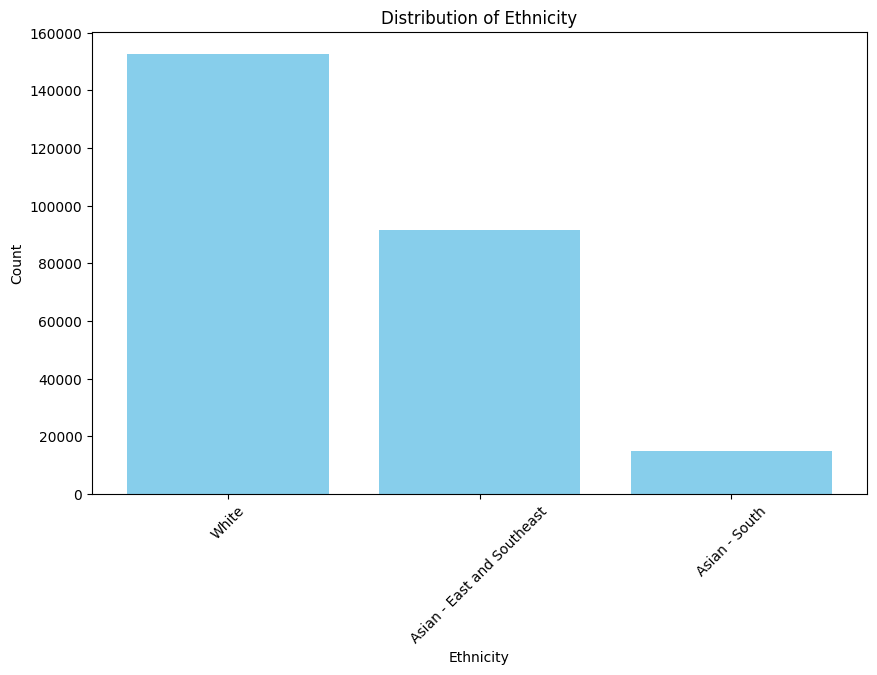

In [8]:
# Count ethnicity distribution
ethnicity_counts = data['ethnicity'].value_counts()
plt.figure(figsize=(10, 6))
# plt.style.use('default')
plt.bar(ethnicity_counts.index, ethnicity_counts.values, color='skyblue')
plt.xlabel('Ethnicity')
plt.ylabel('Count')
plt.title('Distribution of Ethnicity')
plt.xticks(rotation=45)
plt.show()

In [9]:
# Stratified sampling: Select 6000 images per ethnicity
target_per_class = 6000
stratified_samples = []

# For each ethnicity, sample up to 6000
for ethnicity, group in data.groupby('ethnicity'):
    stratified_samples.append(group.sample(
        n=min(target_per_class, len(group)),  # Use all if less than target_per_class
        random_state=42
    ))

# Combine the samples into one DataFrame
data_sample = pd.concat(stratified_samples, ignore_index=True)

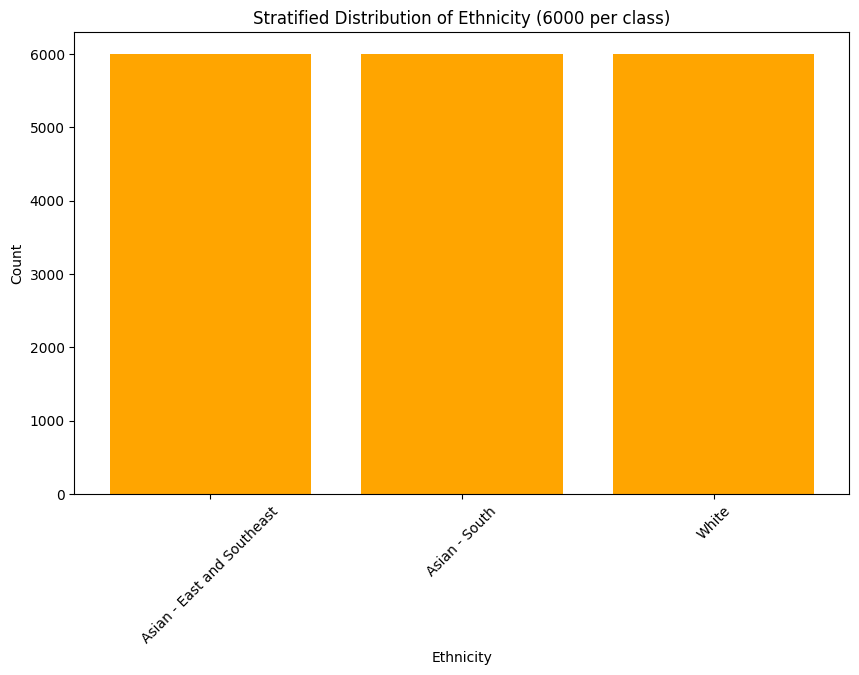

In [10]:
# Show the new distribution of ethnicity
ethnicity_counts = data_sample['ethnicity'].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(ethnicity_counts.index, ethnicity_counts.values, color='orange')
plt.xlabel('Ethnicity')
plt.ylabel('Count')
plt.title('Stratified Distribution of Ethnicity (6000 per class)')
plt.xticks(rotation=45)
plt.show()

### Random data selection

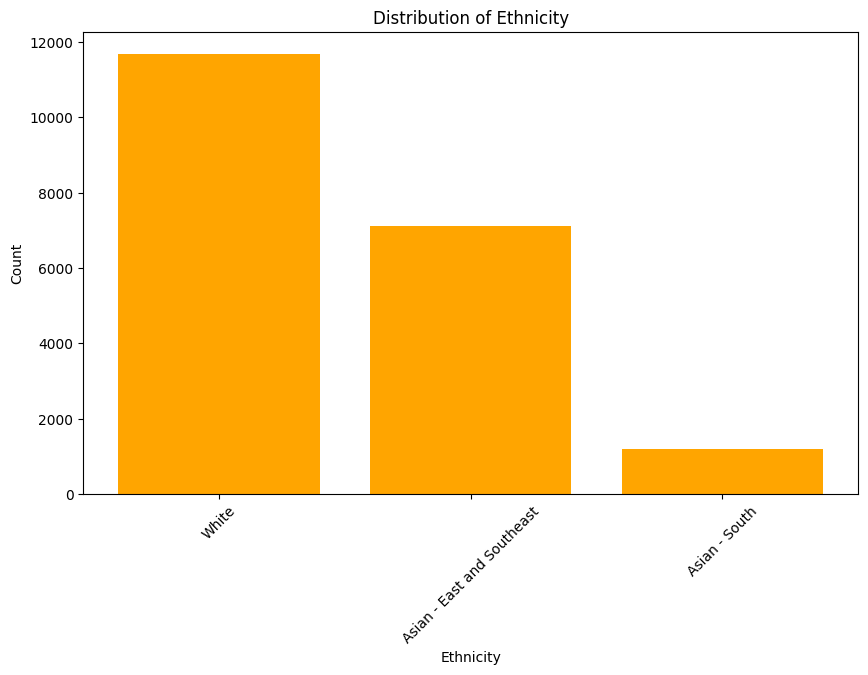

In [10]:
# Randomly select about 2000 images
data_sample = data.sample(n=20000, random_state=42)

# Show the distribution of ethnicity
ethnicity_counts = data_sample['ethnicity'].value_counts()
plt.figure(figsize=(10, 6))
# plt.style.use('default')
plt.bar(ethnicity_counts.index, ethnicity_counts.values, color='orange')
plt.xlabel('Ethnicity')
plt.ylabel('Count')
plt.title('Distribution of Ethnicity')
plt.xticks(rotation=45)
plt.show()

### Data Preprocessing

In [11]:
def preprocess(pngPath, output_dir):
    img = cv2.imread(pngPath, cv2.IMREAD_GRAYSCALE)

    # Create a binary image for the breast by thresholding
    binary_img = cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)[1].astype(np.uint8)

    # Find all the contours in the binary image
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        raise ValueError("No contours found.")
    largest_contour = max(contours, key=cv2.contourArea)

    # Create a mask for the breast region
    mask = np.zeros(img.shape, np.uint8)
    mask = cv2.fillPoly(mask, [largest_contour], 255)

    # Find the bounding box around the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Crop the image
    imgCropped = img[y:y+h, x:x+w]

    # Make the cropped image square by padding
    max_dim = max(w, h)
    padded_img = cv2.copyMakeBorder(
        imgCropped,
        top=(max_dim - h) // 2,
        bottom=(max_dim - h + 1) // 2,
        left=(max_dim - w) // 2,
        right=(max_dim - w + 1) // 2,
        borderType=cv2.BORDER_CONSTANT,
        value=0  # Background color (black)
    )

    # Save the processed image to a unique directory based on the original file path
    patient_dir = os.path.dirname(pngPath).replace("/", "_").replace("\\", "_")
    patient_output_dir = os.path.join(output_dir, patient_dir)
    os.makedirs(patient_output_dir, exist_ok=True)
    output_path = os.path.join(patient_output_dir, os.path.basename(pngPath))
    cv2.imwrite(output_path, imgCropped)
    cv2.imwrite(output_path, padded_img)

    return output_path

In [12]:
# Directory for saving preprocessed images
output_dir = "/tmp/e3/processed_images"
os.makedirs(output_dir, exist_ok=True)

# Prepare LCC-only file paths and labels
lcc_only_filepaths = []
lcc_only_labels = []

for folder_path in data_sample['FilePath']:
    if os.path.exists(folder_path):
        all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.png')]
        lcc_files = [f for f in all_files if "LCC" in f]
        if lcc_files:
            try:
                lcc_cropped_path = preprocess(lcc_files[0], output_dir)
                lcc_only_filepaths.append(lcc_cropped_path)
                patient_id = os.path.basename(os.path.dirname(folder_path))
                matching_rows = data_sample[data_sample['patient_id'] == patient_id]
                if matching_rows.empty:
                    print(f"Warning: No matching label found for patient_id {patient_id}. Skipping.")
                    continue
                label = matching_rows['ethnicity'].iloc[0]
                lcc_only_labels.append(label)
            except Exception as e:
                print(f"Error processing {folder_path}: {e}")

print(f"Number of valid LCC-only images: {len(lcc_only_filepaths)}")
print(f"Distribution of valid LCC-only images: {Counter(lcc_only_labels)}")

# Split dataset into train/test
train_lcc_filepaths, test_lcc_filepaths, train_lcc_labels, test_lcc_labels = train_test_split(
    lcc_only_filepaths, lcc_only_labels, test_size=0.25, stratify=lcc_only_labels, random_state=42
)

Number of valid LCC-only images: 17972
Distribution of valid LCC-only images: Counter({'Asian - East and Southeast': 6011, 'White': 5987, 'Asian - South': 5974})


### Resampling

In [11]:
# Downsample "White" class and upsample "Asian - South" class
white_indices = [i for i, label in enumerate(lcc_only_labels) if label == "White"]
asian_south_indices = [i for i, label in enumerate(lcc_only_labels) if label == "Asian - South"]
asian_east_indices = [i for i, label in enumerate(lcc_only_labels) if label == "Asian - East and Southeast"]

# Determine target size (same as Asian - East and Southeast)
target_size = 300 # len(asian_east_indices)

# Downsample "White"
downsampled_white_indices = random.sample(white_indices, 600)

# Upsample "Asian - South"
upsampled_asian_south_indices = resample(
    asian_south_indices,
    replace=True,
    n_samples=target_size,
    random_state=42
)

# Combine indices
final_indices = downsampled_white_indices + asian_east_indices + upsampled_asian_south_indices

# Create the balanced dataset
balanced_filepaths = [lcc_only_filepaths[i] for i in final_indices]
balanced_labels = [lcc_only_labels[i] for i in final_indices]

# Display the distribution of resampled training labels
print(f"Resampled training dataset size: {len(balanced_filepaths)}")
print(f"Resampled training label distribution: {Counter(balanced_labels)}")

# Count test dataset distribution
print(f"Test dataset size: {len(test_lcc_filepaths)}")
print(f"Test dataset label distribution: {Counter(test_lcc_labels)}")

Resampled training dataset size: 1621
Resampled training label distribution: Counter({'Asian - East and Southeast': 721, 'White': 600, 'Asian - South': 300})
Test dataset size: 400
Test dataset label distribution: Counter({'White': 228, 'Asian - East and Southeast': 145, 'Asian - South': 27})


### Convert to Labels

In [23]:
# Convert LCC labels to numeric format
def encode_labels(labels):
    label_mapping = {label: idx for idx, label in enumerate(set(labels))}
    encoded_labels = [label_mapping[label] for label in labels]
    return encoded_labels, label_mapping

encoded_train_lcc_labels, lcc_label_mapping = encode_labels(train_lcc_labels)
encoded_test_lcc_labels = [lcc_label_mapping[label] for label in test_lcc_labels]

# Prepare LCC-only dataset for training
def create_lcc_dataset(filepaths, labels, augment=False, targeted_classes=None):
    def load_lcc_image(filepath, label):
        # Load and resize the image
        image = tf.image.decode_png(tf.io.read_file(filepath), channels=1)
        image = tf.image.resize(image, [224, 224])

        if augment:
            # Apply horizontal flipping for all classes
            image = tf.image.random_flip_left_right(image)

        # Normalize the image to [0, 1]
        return tf.cast(image, tf.float32) / 255.0, label

    # Create a TensorFlow Dataset
    dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))

    # Apply the load_lcc_image function to each element
    dataset = dataset.map(
        lambda filepath, label: load_lcc_image(filepath, label),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    return dataset

# Create training dataset with augmentation
train_lcc_dataset = create_lcc_dataset(
    train_lcc_filepaths, encoded_train_lcc_labels, augment=True
).batch(16).prefetch(buffer_size=tf.data.AUTOTUNE)

# Create test dataset without augmentation
test_lcc_dataset = create_lcc_dataset(
    test_lcc_filepaths, encoded_test_lcc_labels, augment=False
).batch(16).prefetch(buffer_size=tf.data.AUTOTUNE)


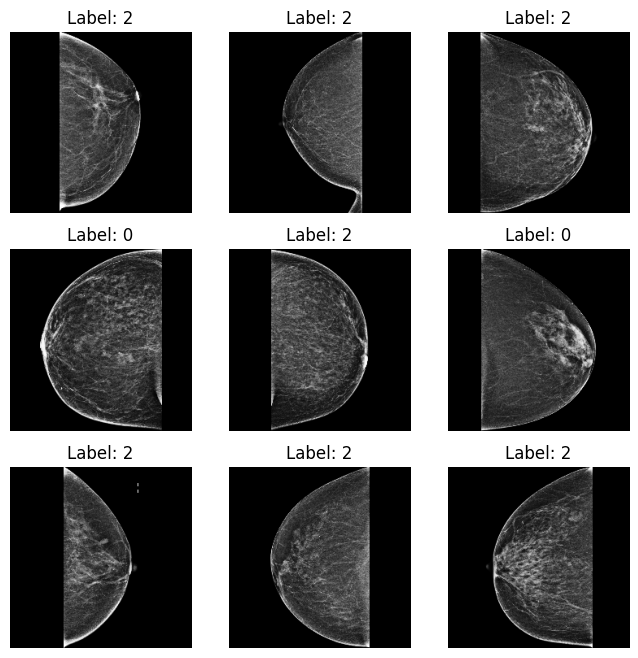

In [24]:
# Function to visualize a batch of images
def show_images_from_dataset(dataset, num_images=9):
    # Take a batch of images and labels
    for images, labels in dataset.take(1):  # Take one batch
        images = images.numpy()  # Convert Tensor to NumPy array
        labels = labels.numpy()

        # Plot images in a grid
        plt.figure(figsize=(8, 8))
        for i in range(min(num_images, images.shape[0])):
            plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].squeeze(), cmap='gray')  # Squeeze in case of single-channel images
            plt.title(f"Label: {labels[i]}")
            plt.axis("off")
        plt.show()
        break  # Only take one batch

# Display a batch from the training dataset
show_images_from_dataset(train_lcc_dataset)

In [25]:
# Define input layer for 1-channel (grayscale) input
input_layer_lcc = Input(shape=(224, 224, 1))

# Convert 1-channel grayscale image to 3-channel input using a 1x1 Conv layer
x = Conv2D(3, (1, 1), activation='linear')(input_layer_lcc)

# Load EfficientNetB3 without passing input_tensor, setting input_shape instead
base_model_lcc = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Apply the grayscale conversion before passing data to EfficientNetB3
x = base_model_lcc(x)

# Freeze base model layers initially
base_model_lcc.trainable = False  

# Add custom layers on top of EfficientNetB3
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output_lcc = Dense(len(lcc_label_mapping), activation='softmax')(x)

# Define the final model
model_lcc = Model(inputs=input_layer_lcc, outputs=output_lcc)

# Compile the model
model_lcc.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Start with a smaller learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history_lcc = model_lcc.fit(
    train_lcc_dataset,
    validation_data=test_lcc_dataset,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
    ]
)

# Fine-tuning (Unfreeze base model for additional training)
base_model_lcc.trainable = True
model_lcc.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train again with fine-tuning
history_finetune = model_lcc.fit(
    train_lcc_dataset,
    validation_data=test_lcc_dataset,
    epochs=20,  # Fewer epochs for fine-tuning
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-7)
    ]
)

Epoch 1/50


2025-02-05 13:39:40.185616: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


843/843 [==============================] - 65s 71ms/step - loss: 1.1023 - accuracy: 0.3339 - val_loss: 1.1001 - val_accuracy: 0.3345 - lr: 1.0000e-04
Epoch 2/50
843/843 [==============================] - 59s 70ms/step - loss: 1.1008 - accuracy: 0.3354 - val_loss: 1.1018 - val_accuracy: 0.3345 - lr: 1.0000e-04
Epoch 3/50
843/843 [==============================] - 59s 70ms/step - loss: 1.1003 - accuracy: 0.3345 - val_loss: 1.0989 - val_accuracy: 0.3345 - lr: 1.0000e-04
Epoch 4/50
843/843 [==============================] - 59s 70ms/step - loss: 1.0998 - accuracy: 0.3330 - val_loss: 1.0998 - val_accuracy: 0.3345 - lr: 1.0000e-04
Epoch 5/50
843/843 [==============================] - 59s 70ms/step - loss: 1.0997 - accuracy: 0.3330 - val_loss: 1.0989 - val_accuracy: 0.3381 - lr: 1.0000e-04
Epoch 6/50
843/843 [==============================] - 59s 70ms/step - loss: 1.0987 - accuracy: 0.3416 - val_loss: 1.0983 - val_accuracy: 0.3332 - lr: 5.0000e-05
Epoch 7/50
843/843 [=========================

2025-02-05 14:21:20.740554: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


843/843 [==============================] - 115s 101ms/step - loss: 0.9591 - accuracy: 0.5182 - val_loss: 1.0052 - val_accuracy: 0.5008 - lr: 1.0000e-05
Epoch 2/20
843/843 [==============================] - 85s 101ms/step - loss: 0.8698 - accuracy: 0.5873 - val_loss: 0.9524 - val_accuracy: 0.5302 - lr: 1.0000e-05
Epoch 3/20
843/843 [==============================] - 85s 101ms/step - loss: 0.8241 - accuracy: 0.6151 - val_loss: 0.9621 - val_accuracy: 0.5288 - lr: 1.0000e-05
Epoch 4/20
843/843 [==============================] - 85s 101ms/step - loss: 0.7862 - accuracy: 0.6462 - val_loss: 0.9299 - val_accuracy: 0.5638 - lr: 5.0000e-06
Epoch 5/20
843/843 [==============================] - 85s 100ms/step - loss: 0.7683 - accuracy: 0.6526 - val_loss: 0.8610 - val_accuracy: 0.5965 - lr: 5.0000e-06
Epoch 6/20
843/843 [==============================] - 85s 100ms/step - loss: 0.7530 - accuracy: 0.6641 - val_loss: 0.9083 - val_accuracy: 0.5720 - lr: 5.0000e-06
Epoch 7/20
843/843 [==================

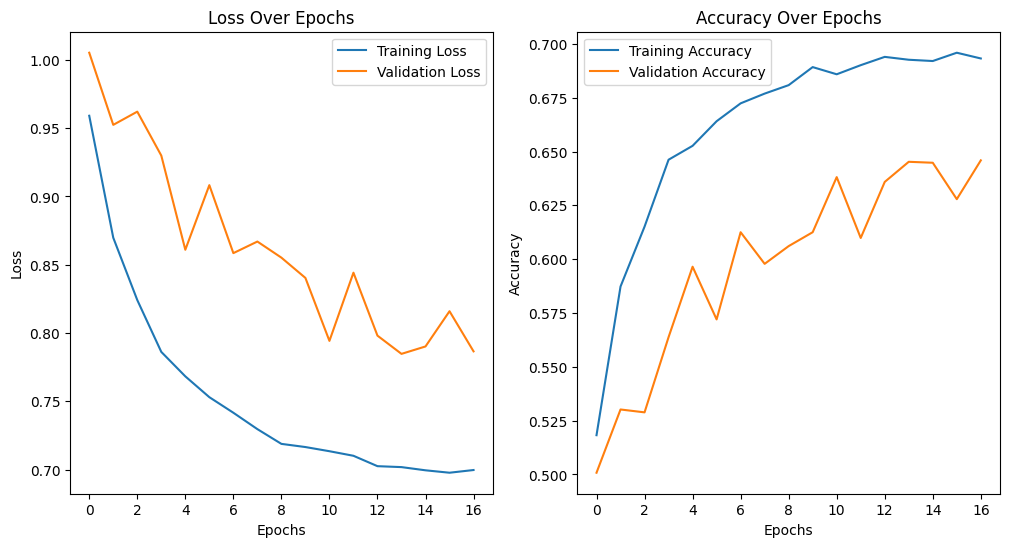

In [26]:
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(history_finetune.history['accuracy'], label='Training Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.subplot(1, 2, 1)
plt.plot(history_finetune.history['loss'], label='Training Loss')
plt.plot(history_finetune.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.show()

281/281 [==============================] - 6s 21ms/step


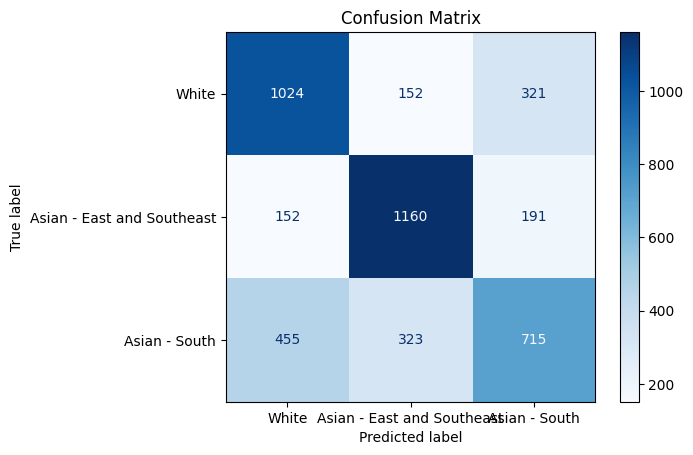

Classification Report:
                            precision    recall  f1-score   support

                     White       0.63      0.68      0.65      1497
Asian - East and Southeast       0.71      0.77      0.74      1503
             Asian - South       0.58      0.48      0.53      1493

                  accuracy                           0.65      4493
                 macro avg       0.64      0.64      0.64      4493
              weighted avg       0.64      0.65      0.64      4493



In [29]:
# Evaluate the model and compute metrics
predictions = model_lcc.predict(test_lcc_dataset)
predicted_labels = tf.argmax(predictions, axis=1).numpy()
true_labels = []
for _, labels in test_lcc_dataset:
    true_labels.extend(labels.numpy())

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=list(lcc_label_mapping.keys())).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Generate classification report
print("Classification Report:")
print(classification_report(
    true_labels,
    predicted_labels,
    target_names=list(lcc_label_mapping.keys()),
    zero_division=1  # Sets undefined metrics to 1 instead of raising warnings
))

In [28]:
# Convert confusion matrix to binary format per class
sensitivity = {}
specificity = {}

for i, class_name in enumerate(lcc_label_mapping.keys()):
    # One-vs-all approach
    TP = conf_matrix[i, i]  # True Positives
    FN = np.sum(conf_matrix[i, :]) - TP  # False Negatives
    FP = np.sum(conf_matrix[:, i]) - TP  # False Positives
    TN = np.sum(conf_matrix) - (TP + FP + FN)  # True Negatives

    # Compute sensitivity & specificity
    sensitivity[class_name] = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity[class_name] = TN / (TN + FP) if (TN + FP) > 0 else 0

# Print results
print("Sensitivity (Recall) per class:")
for class_name, value in sensitivity.items():
    print(f"{class_name}: {value:.4f}")

print("\nSpecificity per class:")
for class_name, value in specificity.items():
    print(f"{class_name}: {value:.4f}")

Sensitivity (Recall) per class:
White: 0.6840
Asian - East and Southeast: 0.7718
Asian - South: 0.4789

Specificity per class:
White: 0.7974
Asian - East and Southeast: 0.8411
Asian - South: 0.8293


In [ ]:
# Save the model
model_lcc.save('Mammo_EfficientNetB3_3class_1024_model.h5')

/home/yu-tingtseng_sa/GitHub/AI-ethnicity-med-image/myenv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### LCC/RCC pairs

In [16]:
# Directory for saving preprocessed images
output_dir = "/tmp/processed_images"
os.makedirs(output_dir, exist_ok=True)

# Find valid LCC/RCC pairs and preprocess them
valid_filepaths = []
labels = []

for folder_path in data_sample['FilePath']:
    if os.path.exists(folder_path):
        all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.png')]
        lcc_files = [f for f in all_files if "LCC" in f]
        rcc_files = [f for f in all_files if "RCC" in f]
        if lcc_files and rcc_files:
            try:
                lcc_cropped_path = preprocess(lcc_files[0], output_dir)
                rcc_cropped_path = preprocess(rcc_files[0], output_dir)
                valid_filepaths.append((lcc_cropped_path, rcc_cropped_path))

                # Extract patient_id from the file path and match it to get ethnicity
                patient_id = os.path.basename(os.path.dirname(folder_path))
                matching_rows = data_sample[data_sample['patient_id'] == patient_id]
                if matching_rows.empty:
                    print(f"Warning: No matching label found for patient_id {patient_id}. Skipping.")
                    continue
                label = matching_rows['ethnicity'].iloc[0]
                labels.append(label)
            except Exception as e:
                print(f"Error processing {folder_path}: {e}")

# Display count of valid pairs
print(f"Number of valid LCC/RCC pairs: {len(valid_filepaths)}")
print(f"Ethnicity distribution in valid pairs: {Counter(labels)}")

Number of valid LCC/RCC pairs: 1995
Ethnicity distribution in valid pairs: Counter({'White': 1139, 'Asian - East and Southeast': 720, 'Asian - South': 136})


In [127]:
# Split into train/test datasets
train_filepaths, test_filepaths, train_labels, test_labels = train_test_split(
    valid_filepaths, labels, test_size=0.2, stratify=labels, random_state=42
)

# Resample only the training dataset
class_groups = {label: [] for label in set(train_labels)}
for filepath_pair, label in zip(train_filepaths, train_labels):
    class_groups[label].append(filepath_pair)

# Define target size for resampling
target_size = 700

balanced_train_filepaths = []
balanced_train_labels = []
for label, group in class_groups.items():
    if len(group) > target_size:
        sampled_group = random.sample(group, target_size)
    else:
        sampled_group = resample(group, replace=True, n_samples=target_size, random_state=42)
    balanced_train_filepaths.extend(sampled_group)
    balanced_train_labels.extend([label] * target_size)

# Check the new distribution
print("New training data distribution:")
print(Counter(balanced_train_labels))

print("Testing data distribution:")
print(Counter(test_labels))

New training data distribution:
Counter({'Asian - South': 700, 'White': 700, 'Asian - East and Southeast': 700})
Testing data distribution:
Counter({'White': 176, 'Asian - East and Southeast': 126, 'Asian - South': 24})


In [128]:
# Convert labels to numeric format
def encode_labels(labels):
    label_mapping = {label: idx for idx, label in enumerate(set(labels))}
    encoded_labels = [label_mapping[label] for label in labels]
    return encoded_labels, label_mapping

encoded_train_labels, label_mapping = encode_labels(balanced_train_labels)
encoded_test_labels = [label_mapping[label] for label in test_labels]

# Prepare dataset for training
def create_pairs_dataset(filepaths, labels, augment=False):
    def load_image_pair(lcc_path, rcc_path, augment):
        lcc_image = tf.image.decode_png(tf.io.read_file(lcc_path), channels=1)
        rcc_image = tf.image.decode_png(tf.io.read_file(rcc_path), channels=1)
        lcc_image = tf.image.resize(lcc_image, [224, 224])
        rcc_image = tf.image.resize(rcc_image, [224, 224])

        if augment:
            # Apply horizontal flipping randomly
            lcc_image = tf.image.random_flip_left_right(lcc_image)
            rcc_image = tf.image.random_flip_left_right(rcc_image)

        combined_image = tf.concat([lcc_image, rcc_image], axis=-1)
        return combined_image

    images = [load_image_pair(lcc, rcc, augment) for lcc, rcc in filepaths]
    return tf.data.Dataset.from_tensor_slices((images, labels))

# Create datasets with augmentation for training only
train_dataset = create_pairs_dataset(balanced_train_filepaths, encoded_train_labels, augment=True).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = create_pairs_dataset(test_filepaths, encoded_test_labels, augment=False).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)


In [129]:
for image_batch, label_batch in train_dataset.take(1):
    print(f"Image batch shape: {image_batch.shape}")
    print(f"Label batch shape: {label_batch.shape}")

Image batch shape: (32, 224, 224, 2)
Label batch shape: (32,)


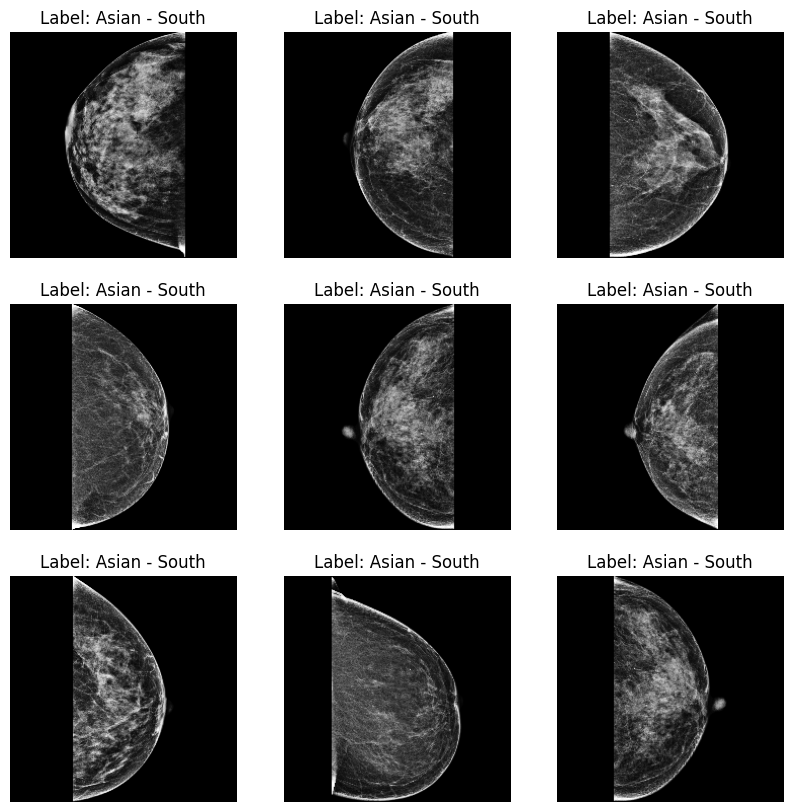

In [130]:
for image_batch, label_batch in train_dataset.shuffle(1000).take(1):  # Shuffle before taking samples
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(tf.squeeze(image_batch[i][:, :, 0].numpy()), cmap="gray")
        label = list(label_mapping.keys())[list(label_mapping.values()).index(label_batch[i].numpy())]
        plt.title(f"Label: {label}")
        plt.axis("off")
    plt.show()


In [131]:
# Build EfficientNetB0 model with preprocessing for 2-channel input
input_layer = Input(shape=(224, 224, 2))
processed_input = Conv2D(3, (1, 1), activation='linear')(input_layer)  # Convert 2 channels to 3
base_model = EfficientNetB0(weights=None, include_top=False, input_tensor=processed_input)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x) # 128
output = Dense(len(label_mapping), activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=30,
    # callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)


Epoch 1/30
66/66 [==============================] - 72s 954ms/step - loss: 2.1030 - accuracy: 0.5329 - val_loss: 1.0257 - val_accuracy: 0.5399
Epoch 2/30
66/66 [==============================] - 57s 862ms/step - loss: 1.2288 - accuracy: 0.5024 - val_loss: 1.1101 - val_accuracy: 0.3865
Epoch 3/30
66/66 [==============================] - 56s 843ms/step - loss: 1.0068 - accuracy: 0.5876 - val_loss: 1.0416 - val_accuracy: 0.5399
Epoch 4/30
66/66 [==============================] - 56s 854ms/step - loss: 1.3065 - accuracy: 0.3957 - val_loss: 0.9728 - val_accuracy: 0.3865
Epoch 5/30
66/66 [==============================] - 57s 865ms/step - loss: 1.2008 - accuracy: 0.2290 - val_loss: 1.0884 - val_accuracy: 0.3865
Epoch 6/30
66/66 [==============================] - 56s 853ms/step - loss: 1.2050 - accuracy: 0.6562 - val_loss: 1.0644 - val_accuracy: 0.3865
Epoch 7/30
66/66 [==============================] - 56s 844ms/step - loss: 1.1431 - accuracy: 0.3243 - val_loss: 1.1396 - val_accuracy: 0.3865

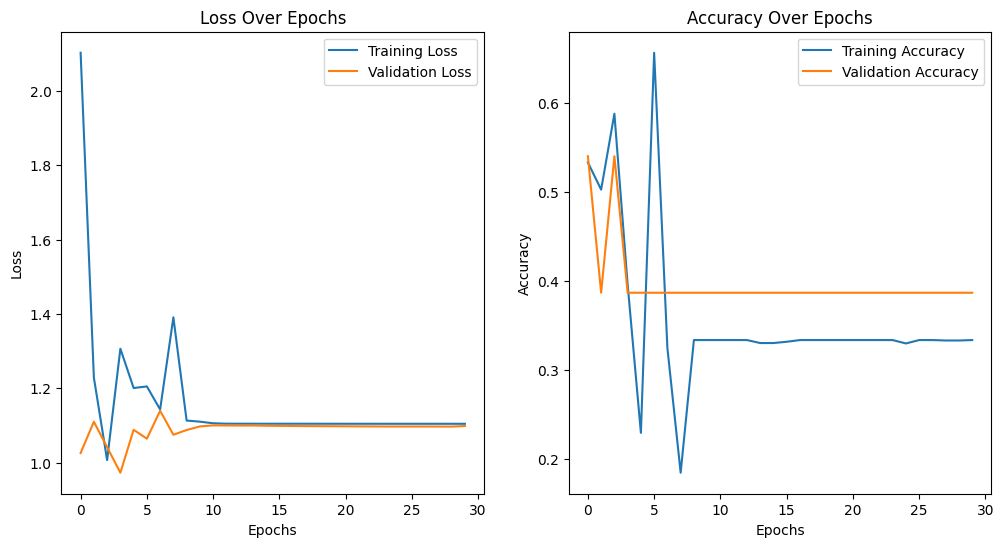

In [132]:
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.show()

11/11 [==============================] - 8s 291ms/step


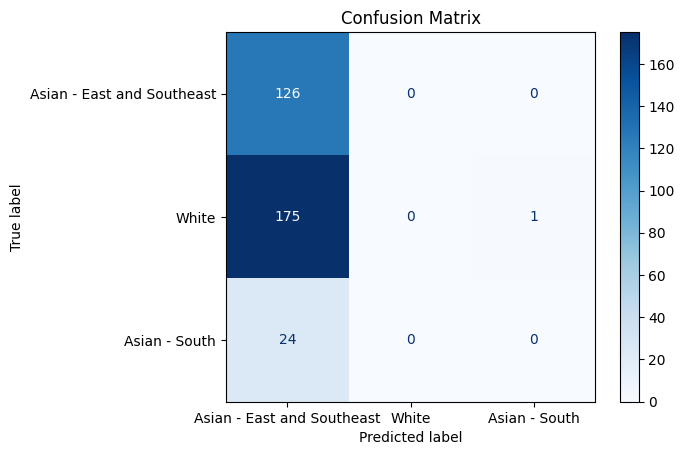

Classification Report:
                            precision    recall  f1-score   support

Asian - East and Southeast       0.39      1.00      0.56       126
                     White       1.00      0.00      0.00       176
             Asian - South       0.00      0.00      1.00        24

                  accuracy                           0.39       326
                 macro avg       0.46      0.33      0.52       326
              weighted avg       0.69      0.39      0.29       326



In [133]:
# Evaluate the model and compute metrics
predictions = model.predict(test_dataset)
predicted_labels = tf.argmax(predictions, axis=1).numpy()
true_labels = []
for _, labels in test_dataset:
    true_labels.extend(labels.numpy())

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=list(label_mapping.keys())).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Generate classification report
print("Classification Report:")
print(classification_report(
    true_labels,
    predicted_labels,
    target_names=list(label_mapping.keys()),
    zero_division=1  # Sets undefined metrics to 1 instead of raising warnings
))


In [134]:
# Analyze predicted and true label distributions

print("Predicted label distribution:", Counter(predicted_labels))
print("True label distribution:", Counter(true_labels)) # Test label

Predicted label distribution: Counter({0: 325, 2: 1})
True label distribution: Counter({1: 176, 0: 126, 2: 24})
